In [38]:
import gym 
import torch
from collections import deque
import random
from torch.autograd import Variable
env = gym.envs.make("MountainCar-v0")


In [55]:
class DQN():
    def __init__(self, n_state, n_action, n_hidden = 50, lr= 0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_state, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_action)
        )

        self.optimizer = torch.optim.Adam(
            self.model.parameters(),lr
        )
    def update(self, s,y):
        """
        Update the weights of the DQN given a training sample
        @param s : state
        @param y: target value
        """

        y_pred = self.model(torch.Tensor(s))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, s ):
        with torch.no_grad():
            return self.model(torch.Tensor(s))

    def replay(self, memory, replay_size, gamma):
        if len(memory) >= replay_size:
            replay_data = random.sample(memory, replay_size)
            states =[]
            td_targets =[]
            for state,action, next_state, reward, is_done in replay_data:
                print("state",state)
                states.append(state)
                q_values = self.predict(state).tolist()
                if is_done:
                    q_values[action] = reward
                else:
                    q_values_next = self.predict(next_state)
                    q_values[action] = reward + gamma*torch.max(q_values_next).item()

                td_targets.append(q_values)

            self.update(states, td_targets)

            




In [56]:
def gen_epsilon_greedy_policy(estimator, epsilon , n_action):
    def policy_function(state):
        if random.random() < epsilon:
            return random.randint(0, n_action -1 )

        else :
            q_values = estimator.predict(state)
            return torch.argmax(q_values).item()

    return policy_function


In [57]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 50
lr = 0.001
dqn = DQN(n_state, n_action , n_hidden, lr)


In [58]:
memory = deque(maxlen=10000)


In [59]:
def q_learning(env, estimator, n_episode , replay_size, gamma= 1.0,epsilon=0.1, epsilon_decay =0.99):
    for episode in range(n_episode):
        policy = gen_epsilon_greedy_policy(
            estimator, epsilon, n_action
        )
        state,_ = env.reset()
        is_done = False
        while not is_done:
            action = policy(state)
            next_state, reward, is_done ,_, _ = env.step(action)
            total_reward_episode[episode] += reward
            modififed_reward = next_state[0] + 0.5
            if next_state[0] >= 0.5:
                modififed_reward +=100

            elif next_state[0] >= 0.25:
                modififed_reward +=20

            elif next_state[0] >= 0.1:
                modififed_reward +=10

            elif next_state[0] >= 0: 
                modififed_reward += 5

            memory.append((state,action,next_state, modififed_reward,  is_done))

            if is_done :
                break
                
            estimator.replay(memory, replay_size, gamma)
            state = next_state

        print('Episode:{} , total reward:{}, epsilon: {}'.format(episode, total_reward_episode[episode],epsilon))

        epsilon = max(epsilon* epsilon_decay, 0.01)




In [60]:
n_episode = 600


In [61]:
replay_size = 20

In [62]:
total_reward_episode = [0]*n_episode
q_learning(env, dqn,n_episode, replay_size, gamma=0.9)

state [-0.5250701  0.0120507]
state [-0.38400295  0.01720002]
state [-0.51200837  0.01306174]
state [-0.40120295  0.0170975 ]
state [-0.54807013  0.00976595]
state [-0.57353556  0.00581677]
state [-0.4517042   0.01606463]
state [-0.5663457  0.0071899]
state [-0.4351746   0.01652959]
state [-0.5793523   0.00440056]
state [-0.58375293  0.00295185]
state [-0.46776885  0.0154814 ]
state [-0.41830045  0.01687416]
state [-0.58670473  0.00148138]
state [-0.48325023  0.01478328]
state [-0.55783606  0.00850962]
state [-0.5371208   0.01094932]
state [-0.36681956  0.01718338]
state [-0.58818614  0.        ]
state [-0.49803352  0.01397483]
state [-0.48325023  0.01478328]
state [-0.36681956  0.01718338]
state [-0.40120295  0.0170975 ]
state [-0.49803352  0.01397483]
state [-0.55783606  0.00850962]
state [-0.4517042   0.01606463]
state [-0.41830045  0.01687416]
state [-0.5663457  0.0071899]
state [-0.58670473  0.00148138]
state [-0.5793523   0.00440056]
state [-0.5250701  0.0120507]
state [-0.435174

KeyboardInterrupt: 

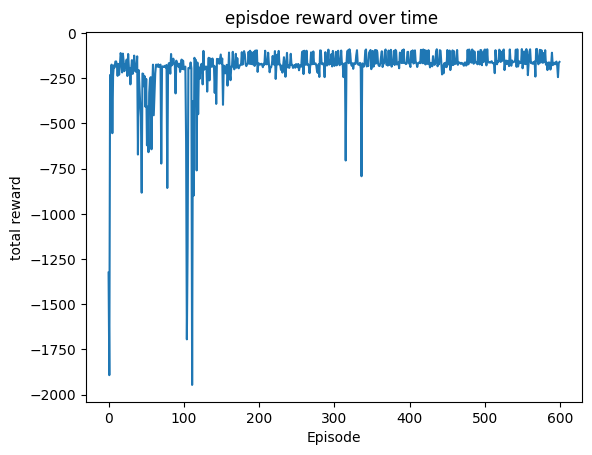

In [ ]:
import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('episdoe reward over time ')
plt.xlabel('Episode')
plt.ylabel('total reward')
plt.show()